<a href="https://colab.research.google.com/github/Spiegeldondi/double-pendulum/blob/main/multiple_pendulums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double Pendulum Simulation with Multiprocessing

## Overview
This Jupyter Notebook presents a simulation of multiple double pendulums. A double pendulum is a classic example of a chaotic system, where slight variations in initial conditions can lead to significantly different behaviors. This makes it an excellent candidate for studying chaos theory.

## The Double Pendulum
Each double pendulum in our simulation consists of two arms and two masses. The movement of these pendulums is governed by complex physics, making their behavior unpredictable over longer periods. These systems are often studied in physics and mathematics to illustrate chaotic motion.

## Why Multiprocessing?
### Performance Benefits
In our case, we simulate multiple double pendulums with slightly varied initial conditions to observe how these small differences evolve over time. Doing these simulations one after the other would be time-consuming, especially as the number of simulations increases. This is where **multiprocessing** comes into play.

### Parallel Processing
Multiprocessing allows us to distribute these simulations across multiple CPU cores, significantly speeding up the process. By running simulations in parallel, we can observe the diverging trajectories of similarly-started pendulums much more quickly.

### Python's Multiprocessing Library
We use Python's `multiprocessing` library, a powerful tool that enables parallel execution of tasks. This approach is particularly effective for CPU-bound tasks like our simulations.

## Visualization
After running the simulations, we use Matplotlib to create animations showing the trajectories of each pendulum. This visual representation helps us directly observe the chaotic nature of the double pendulum system and the impact of initial conditions on their motion.


In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Constants
g = 9.81  # acceleration due to gravity
l1 = 1.0  # length of pendulum 1
l2 = 1.0  # length of pendulum 2
m1 = 1.0  # mass of pendulum 1
m2 = 1.0  # mass of pendulum 2
b1 = 0.05 # damping coefficient of pendulum 1
b2 = 0.05 # damping coefficient of pendulum 2

In [3]:
def ode_system(y, t, l1, l2, m1, m2, b1, b2):
    """
    Transform the second-order ODEs of a damped double pendulum into first-order ODEs.

    The original problem, formulated in terms of second-order differential equations for the angles,
    is transformed into a system of first-order equations that can be solved numerically.

    Parameters:
    y (array): An array representing the current state [θ1, z1, θ2, z2].
               θ1, θ2 are the angles, and z1, z2 are the angular velocities of the pendulums.
    t (float): Current time. Not used in this calculation but required for odeint.
    l1 (float): Length of the first pendulum.
    l2 (float): Length of the second pendulum.
    m1 (float): Mass of the first pendulum.
    m2 (float): Mass of the second pendulum.
    b1 (float): Damping coefficient for the first pendulum.
    b2 (float): Damping coefficient for the second pendulum.

    Returns:
    list: First-order derivatives [θ1dot, z1dot, θ2dot, z2dot].
    """

    θ1, z1, θ2, z2 = y  # Unpack the current angles and angular velocities

    # Calculate cosine and sine of the angle difference for simplicity in equations
    c, s = np.cos(θ1-θ2), np.sin(θ1-θ2)

    # θ1dot and θ2dot are the angular velocities, which are the first derivatives of θ1 and θ2
    θ1dot = z1
    θ2dot = z2

    # Derive the first derivatives of the angular velocities (z1dot, z2dot)
    # These derivatives represent the angular accelerations of the pendulums
    z1dot = (m2*g*np.sin(θ2)*c - m2*s*(l1*z1**2*c + l2*z2**2) -
             (m1+m2)*g*np.sin(θ1) - b1*z1) / l1 / (m1 + m2*s**2)

    z2dot = ((m1+m2)*(l1*z1**2*s - g*np.sin(θ2) + g*np.sin(θ1)*c) +
             m2*l2*z2**2*s*c - b2*z2) / l2 / (m1 + m2*s**2)

    # Return the first-order derivatives as a list
    return θ1dot, z1dot, θ2dot, z2dot

In [4]:
# Specifications for the simulation playback
duration = 60  # duration of the simulation in seconds
fps = 25  # frames per second
num_frames = duration * fps  # total number of frames

# Time array
t = np.linspace(0, duration, num_frames)

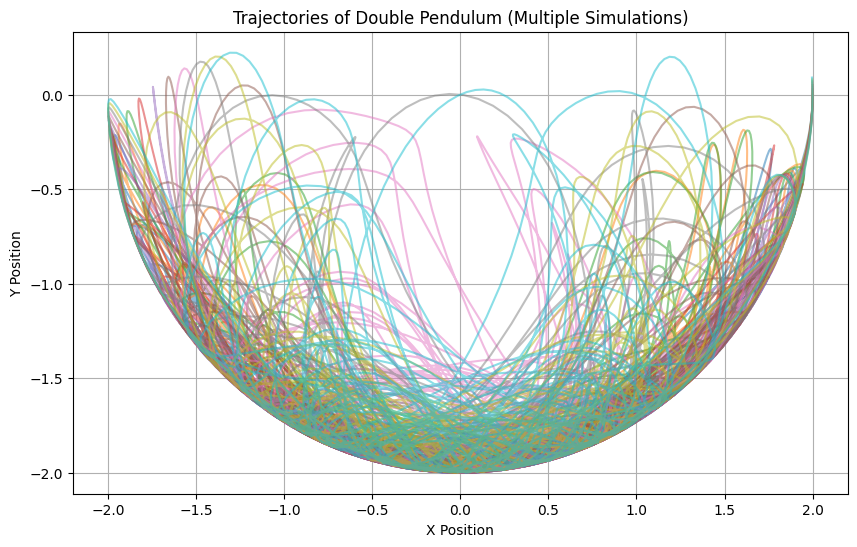

In [5]:
import multiprocessing

def run_simulation(initial_conditions):
    """Run a single double pendulum simulation with given initial conditions."""
    result = odeint(ode_system, initial_conditions, t, args=(l1, l2, m1, m2, b1, b2))
    θ1, θ2 = result[:, 0], result[:, 2]
    x1 = l1 * np.sin(θ1)
    y1 = -l1 * np.cos(θ1)
    x2 = x1 + l2 * np.sin(θ2)
    y2 = y1 - l2 * np.cos(θ2)
    return x1, y1, x2, y2

def plot_trajectories(results):
    """Plot trajectories from multiple simulations."""
    plt.figure(figsize=(10, 6))
    for x1, y1, x2, y2 in results:
        plt.plot(x2, y2, '-', alpha=0.5)  # Plotting only the trajectory of the second pendulum
    plt.title('Trajectories of Double Pendulum (Multiple Simulations)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid()
    plt.show()

def animate(i, lines, results):
    # Update positions for all pendulums at frame i
    for line_idx, (x1, y1, x2, y2) in enumerate(results):
        lines[line_idx][0].set_data([0, x1[i]], [0, y1[i]])
        lines[line_idx][1].set_data([x1[i], x2[i]], [y1[i], y2[i]])
    return [line for line_pair in lines for line in line_pair]


# Number of simulations
num_simulations = 10

# Slightly varied initial conditions
initial_conditions = [np.array([np.pi/2, 0, np.pi/2 + i*0.01, -i*0.1]) for i in range(num_simulations)]

# Use multiprocessing to run simulations in parallel
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        results = pool.map(run_simulation, initial_conditions)

    # Plot the results
    plot_trajectories(results)

In [6]:
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')

# Set up the Matplotlib animation
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
lines = [[ax.plot([], [], 'o-', lw=2)[0], ax.plot([], [], 'o-', lw=2)[0]] for _ in range(10)]

# Close matplotlib figure plot
plt.close()

# Create the animation
ani = animation.FuncAnimation(fig, animate, fargs=(lines, results), frames=len(results[0][0]), interval=20)

# Show the animation
ani